In [23]:
import zipfile
import numpy as np
import io
import scipy.signal as signal
import os
import matplotlib.pyplot as plt
from scipy.signal import welch
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix, f1_score
from tqdm import tqdm
import time
import warnings
import random
warnings.filterwarnings('ignore')

# declare seed for determinstic results! 
seed = 21
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# defs 
def extract(zips):
    signals = []
    with zipfile.ZipFile(zips, 'r') as z:
        for fname in z.namelist():
            if fname.endswith(".TXT") or fname.endswith(".txt"):
                with z.open(fname) as f:
                    data = np.loadtxt(io.TextIOWrapper(f, encoding='utf-8'))
                    signals.append(data)

    return np.array(signals)

# noise filtering
def butterworth(lowfreq, highfreq, fs, order=4):
    nyq = 0.5 * fs
    low = lowfreq / nyq
    high = highfreq / nyq
    b, a = signal.butter(order, [low, high], btype="bandpass")
    return b, a

def apply_filter(data, lowfreq, highfreq, fs, order=4):
    b, a = butterworth(lowfreq, highfreq, fs, order=order)
    return signal.filtfilt(b, a, data)

def applyFilter(dataset, lowfreq, highfreq, fs, order=4):
    filtered_set = []
    for sig in dataset:
        filtered_set.append(apply_filter(sig, lowfreq, highfreq, fs, order=order))
    return np.array(filtered_set)

# segmentation using sliding window
def segment(signals, window_size=256, overlap=0.5):
    step_size = int(window_size * (1 - overlap))
    all_segments = []
    for sig in signals:
        num_windows = (len(sig) - window_size) // step_size + 1
        for i in range(num_windows):
            start = i * step_size
            end = start + window_size
            all_segments.append(sig[start:end])
    return np.array(all_segments)

# normalization 
def normalize_z(data):
    normalized_data = []
    for segment in data:
        mean = np.mean(segment)
        std = np.std(segment)
        if std > 0:
            normalized_segment = (segment - mean) / std
        else:
            # handles NaN makes list of 0's
            normalized_segment = segment - mean
        normalized_data.append(normalized_segment)
    return np.array(normalized_data)


# global init variables
fs = 173.61
low = 0.5
high = 40.0
order = 4
window_size = 256

os.makedirs('data/processed_data', exist_ok=True)

zip_paths = {
    'A': 'data/zips/set_A.zip',
    'B': 'data/zips/set_B.zip',
    'C': 'data/zips/set_C.zip',
    'D': 'data/zips/set_D.zip',
    'E': 'data/zips/set_E.zip'
}

# pipeline
for set_name, path in zip_paths.items():
    print(f"Processing Set {set_name}...")

    # extract
    eeg_raw = extract(path)
    print(f"Extracted {len(eeg_raw)} signals.")

    # butterworth in loop
    eeg_filtered = applyFilter(eeg_raw, low, high, fs, order)
    print("Applied Butterworth filter.")

    # segment
    eeg_segmented = segment(eeg_filtered, window_size=window_size)
    print(f"Segmented into {len(eeg_segmented)} windows.")

    # norm
    eeg_normalized = normalize_z(eeg_segmented)
    print("Applied Z-score normalization")
    
    eeg_processed = eeg_normalized
    # save for classification
    
    save_path = f'data/processed_data/processed_{set_name}.npy'
    np.save(save_path, eeg_processed)
    print("Done.\n")

print("Pre-processing complete!")
print("Saved in 'data/processed_data'\n")

Processing Set A...
Extracted 100 signals.
Applied Butterworth filter.
Segmented into 3100 windows.
Applied Z-score normalization
Done.

Processing Set B...
Extracted 100 signals.
Applied Butterworth filter.
Segmented into 3100 windows.
Applied Z-score normalization
Done.

Processing Set C...
Extracted 100 signals.
Applied Butterworth filter.
Segmented into 3100 windows.
Applied Z-score normalization
Done.

Processing Set D...
Extracted 100 signals.
Applied Butterworth filter.
Segmented into 3100 windows.
Applied Z-score normalization
Done.

Processing Set E...
Extracted 100 signals.
Applied Butterworth filter.
Segmented into 3100 windows.
Applied Z-score normalization
Done.

Pre-processing complete!
Saved in 'data/processed_data'



In [2]:
class cnn_model(nn.Module):
    def __init__(self, num_classes=2, input_length=256):
        super(cnn_model, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()

        # dynamically compute flatten size
        with torch.no_grad():
            x = torch.zeros(1, 1, input_length)
            x = self.pool(self.relu(self.conv1(x)))
            x = self.pool(self.relu(self.conv2(x)))
            flatten_dim = x.numel()

        self.fc1 = nn.Linear(flatten_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_and_evaluate(X1, X2, c1_name, c2_name, model_def, input_len=256):
    lr_grid = [0.1, 0.01, 0.001]
    winning_auc = 0
    winning_lr = None
    results = {}
    
    total_start = time.time()

    X = np.concatenate([X1, X2], axis=0)
    y = np.concatenate([np.zeros(X1.shape[0]), np.ones(X2.shape[0])])
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    for lr in lr_grid:
        print(f"\nTraining Learning Rate: {lr}")
        
        kf = KFold(n_splits=10, shuffle=True, random_state=seed)
        
        fold_aucs, fold_accuracies, fold_sensitivities, fold_specificities, fold_f1s = [], [], [], [], []

        for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor)):
            X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
            y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

            smote = SMOTE(random_state=seed)
            X_train_res, y_train_res = smote.fit_resample(X_train.numpy(), y_train.numpy())

            X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32).unsqueeze(1)
            y_train_tensor = torch.tensor(y_train_res, dtype=torch.long)
            X_test_tensor = X_test.unsqueeze(1)
            y_test_tensor = y_test

            train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
            test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)
            
            model = model_def(num_classes=2, input_length=input_len)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

            # trainin 
            model.train()
            for epoch in range(10):
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            # eval
            model.eval()
            y_scores, y_true, y_pred = [], [], []
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    probs = torch.softmax(outputs, dim=1)
                    y_scores.extend(probs[:, 1].cpu().numpy())
                    _, preds = torch.max(outputs, 1)
                    y_pred.extend(preds.cpu().numpy())
                    y_true.extend(labels.cpu().numpy())

            acc = np.mean(np.array(y_pred) == np.array(y_true)) * 100
            auc_score = roc_auc_score(y_true, y_scores)
            
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            f1 = f1_score(y_true, y_pred, zero_division=0)
            
            fold_accuracies.append(acc)
            fold_aucs.append(auc_score)
            fold_sensitivities.append(sensitivity)
            fold_specificities.append(specificity)
            fold_f1s.append(f1)
            

            print(f"Fold {fold+1}/10 | Acc: {acc:.2f}% | AUC: {auc_score:.4f} | Sens: {sensitivity:.4f} | Spec: {specificity:.4f} | F1: {f1:.4f}")
            
        mean_auc = np.mean(fold_aucs)
        mean_acc = np.mean(fold_accuracies)
        mean_sensitivity = np.mean(fold_sensitivities)
        mean_specificity = np.mean(fold_specificities)
        mean_f1 = np.mean(fold_f1s)
        
        print(f"--- Averages for LR {lr} ---")
        print(f"Mean Acc: {mean_acc:.2f}% | Mean AUC: {mean_auc:.4f} | Mean Sens: {mean_sensitivity:.4f} | Mean Spec: {mean_specificity:.4f} | Mean F1: {mean_f1:.4f}")
        
        results[lr] = {'mean_acc': np.mean(fold_accuracies), 'std_acc': np.std(fold_accuracies)}

        if mean_auc > winning_auc:
            winning_auc = mean_auc
            winning_lr = lr

    total_end = time.time()

    print(f"\nBest LR = {winning_lr} | AUC = {winning_auc:.4f}")
    print(f"Total CV Time: {total_end - total_start:.2f}s")

    return winning_lr


def conv1d_filters_to_numpy(conv_layer):
    return conv_layer.weight.detach().cpu().numpy()

def compute_dft_magnitude(filters, nfft=1024):
    mags = np.abs(np.fft.rfft(filters, n=nfft))
    freqs = np.fft.rfftfreq(nfft, d=1.0)
    return freqs, mags

def plot_filter_spectra(freqs, mags, fs, title="", max_filters=8, save_path=None):
    plt.figure(figsize=(10, 6))
    scaled_freqs = freqs * (fs / 2) 
    for i in range(min(mags.shape[0], max_filters)):
        plt.plot(scaled_freqs, mags[i].mean(axis=0), label=f'Filter {i+1}')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(f"{title} Filter DFT Magnitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to {save_path}")
    plt.show()

# lipschitz defined as 
def estimate_lipschitz(model):
    norms = []
    for layer in model.modules():
        if isinstance(layer, (nn.Conv1d, nn.Linear)):
            w = layer.weight.detach().cpu().numpy().reshape(layer.weight.shape[0], -1)
            s = np.linalg.svd(w, compute_uv=False)
            norms.append(np.max(s))
    L_hat = np.prod(norms)
    return L_hat, norms

print('ready to train...')

ready to train...


#### The following equation used in **`estimate_lipschitz(model)`**
$$
\sum_{N \in V} \| f_N - \tilde{f}_N \|_2^2 \le L \| f - \tilde{f} \|_2^2, \\
\text{where } V = \bigcup_{m=1}^{M} V_m \text{ is the collection of all output-generating nodes}
$$

In [3]:
# load fully Preprocessed npy
processed_A = np.load("data/processed_data/processed_A.npy")
processed_B = np.load("data/processed_data/processed_B.npy")
processed_C = np.load("data/processed_data/processed_C.npy")
processed_D = np.load("data/processed_data/processed_D.npy")
processed_E = np.load("data/processed_data/processed_E.npy")

# A vs E Train & Interpretability Visuals


Training Learning Rate: 0.1
Fold 1/10 | Acc: 94.68% | AUC: 0.9926 | Sens: 0.9010 | Spec: 0.9905 | F1: 0.9430
Fold 2/10 | Acc: 97.26% | AUC: 0.9955 | Sens: 0.9604 | Spec: 0.9842 | F1: 0.9716
Fold 3/10 | Acc: 95.65% | AUC: 0.9933 | Sens: 0.9299 | Spec: 0.9837 | F1: 0.9558
Fold 4/10 | Acc: 95.00% | AUC: 0.9894 | Sens: 0.9590 | Spec: 0.9406 | F1: 0.9515
Fold 5/10 | Acc: 92.90% | AUC: 0.9827 | Sens: 0.9094 | Spec: 0.9486 | F1: 0.9274
Fold 6/10 | Acc: 96.45% | AUC: 0.9948 | Sens: 0.9773 | Spec: 0.9518 | F1: 0.9649
Fold 7/10 | Acc: 91.77% | AUC: 0.9851 | Sens: 0.8728 | Spec: 0.9716 | F1: 0.9204
Fold 8/10 | Acc: 94.68% | AUC: 0.9916 | Sens: 0.9748 | Spec: 0.9175 | F1: 0.9493
Fold 9/10 | Acc: 95.32% | AUC: 0.9933 | Sens: 0.9139 | Spec: 0.9906 | F1: 0.9501
Fold 10/10 | Acc: 97.26% | AUC: 0.9960 | Sens: 0.9583 | Spec: 0.9849 | F1: 0.9701
--- Averages for LR 0.1 ---
Mean Acc: 95.10% | Mean AUC: 0.9914 | Mean Sens: 0.9357 | Mean Spec: 0.9664 | Mean F1: 0.9504

Training Learning Rate: 0.01
Fold 1/1

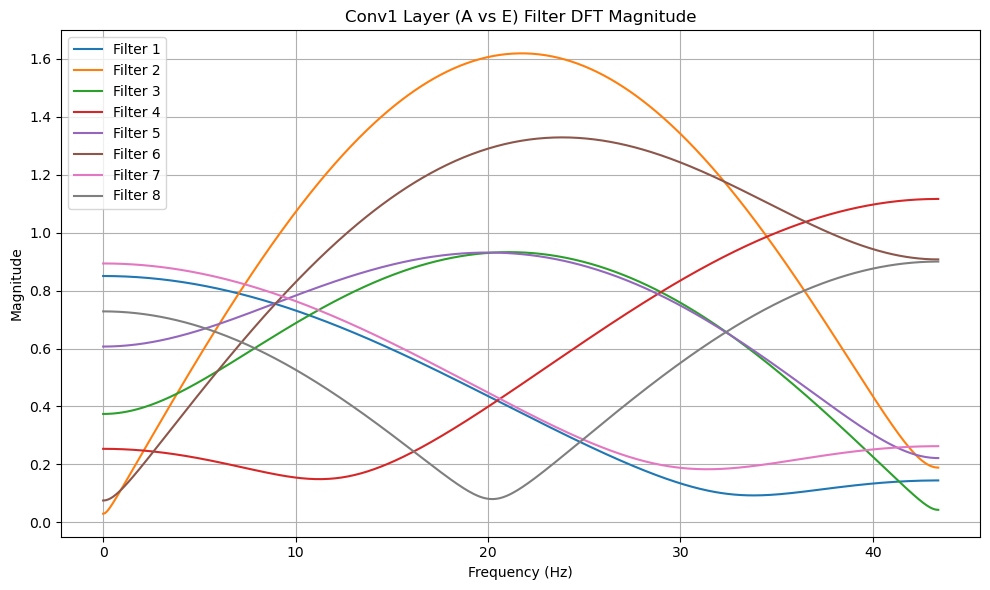

Estimated Lipschitz bound: 43.686897
Per-layer spectral norms: [2.8237364, 2.3290386, 2.724798, 2.437901]


In [4]:
# A vs E 
best_lr = train_and_evaluate(processed_A, processed_E, "A", "E", cnn_model, input_len=256)

model_A_E = cnn_model(num_classes=2, input_length=256)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_A_E.parameters(), lr=best_lr, momentum=0.9, weight_decay=1e-4)

X = np.concatenate([processed_A, processed_E], axis=0)
y = np.concatenate([np.zeros(processed_A.shape[0]), np.ones(processed_E.shape[0])])

# train and eval with best LR
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=64, shuffle=True)

for epoch in range(10):
    model_A_E.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_A_E(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("\nFinal model trained — running interpretability...")

# dft learned features
filters = conv1d_filters_to_numpy(model_A_E.conv1)
freqs, mags = compute_dft_magnitude(filters, nfft=1024)
plot_filter_spectra(freqs, mags, fs=173.61, title="Conv1 Layer (A vs E)", save_path="plots/dft_A.png")

# lipschitz continuity 
L_hat, norms = estimate_lipschitz(model_A_E)
print("Estimated Lipschitz bound:", L_hat)
print("Per-layer spectral norms:", norms)

# save model
torch.save(model_A_E.state_dict(), "models/final_model_A_vs_E.pth")

# B vs E Train & Interpretability Visuals


Training Learning Rate: 0.1
Fold 1/10 | Acc: 88.87% | AUC: 0.9582 | Sens: 0.9076 | Spec: 0.8707 | F1: 0.8885
Fold 2/10 | Acc: 95.65% | AUC: 0.9917 | Sens: 0.9241 | Spec: 0.9874 | F1: 0.9540
Fold 3/10 | Acc: 95.16% | AUC: 0.9904 | Sens: 0.9490 | Spec: 0.9542 | F1: 0.9521
Fold 4/10 | Acc: 95.81% | AUC: 0.9916 | Sens: 0.9401 | Spec: 0.9769 | F1: 0.9582
Fold 5/10 | Acc: 91.61% | AUC: 0.9870 | Sens: 0.8479 | Spec: 0.9839 | F1: 0.9097
Fold 6/10 | Acc: 90.32% | AUC: 0.9748 | Sens: 0.8350 | Spec: 0.9711 | F1: 0.8958
Fold 7/10 | Acc: 91.13% | AUC: 0.9858 | Sens: 0.8462 | Spec: 0.9894 | F1: 0.9123
Fold 8/10 | Acc: 94.03% | AUC: 0.9841 | Sens: 0.9085 | Spec: 0.9736 | F1: 0.9396
Fold 9/10 | Acc: 91.29% | AUC: 0.9722 | Sens: 0.8642 | Spec: 0.9591 | F1: 0.9062
Fold 10/10 | Acc: 53.55% | AUC: 0.5752 | Sens: 0.0000 | Spec: 1.0000 | F1: 0.0000
--- Averages for LR 0.1 ---
Mean Acc: 88.74% | Mean AUC: 0.9411 | Mean Sens: 0.8023 | Mean Spec: 0.9666 | Mean F1: 0.8317

Training Learning Rate: 0.01
Fold 1/1

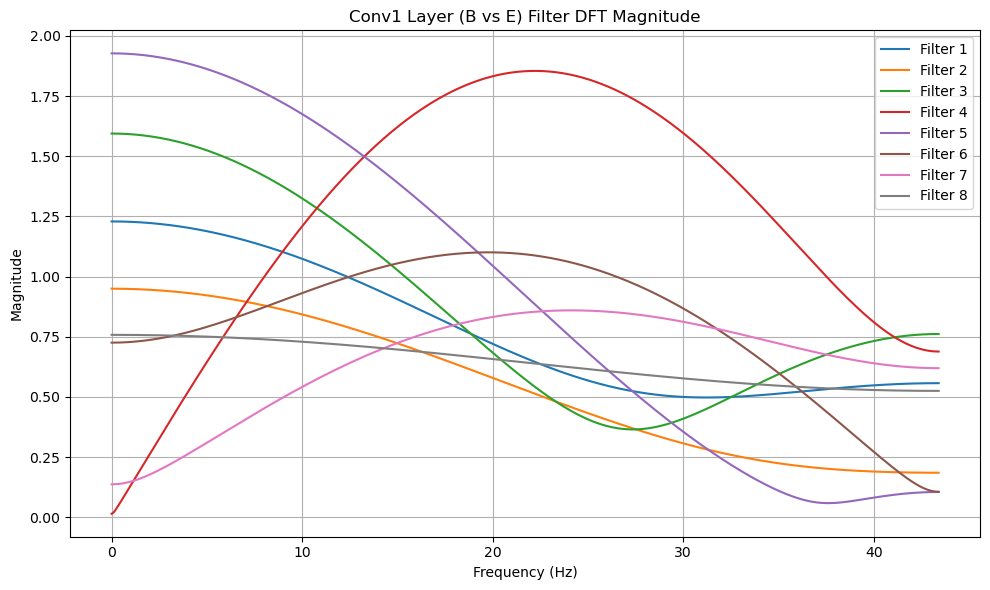

Estimated Lipschitz bound: 24.714943
Per-layer spectral norms: [2.5589714, 2.0266948, 1.740607, 2.7378213]


In [5]:
# B vs E 
best_lr = train_and_evaluate(processed_B, processed_E, "B", "E", cnn_model, input_len=256)

model_B_E = cnn_model(num_classes=2, input_length=256)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_B_E.parameters(), lr=best_lr, momentum=0.9, weight_decay=1e-4)

X = np.concatenate([processed_B, processed_E], axis=0)
y = np.concatenate([np.zeros(processed_B.shape[0]), np.ones(processed_E.shape[0])])

# train and eval with best LR
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=64, shuffle=True)

for epoch in range(10):
    model_B_E.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_B_E(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("\nFinal model trained — running interpretability...")

# dft learned features
filters = conv1d_filters_to_numpy(model_B_E.conv1)
freqs, mags = compute_dft_magnitude(filters, nfft=1024)
plot_filter_spectra(freqs, mags, fs=173.61, title="Conv1 Layer (B vs E)", save_path="plots/dft_B.png")

# lipschitz continuity 
L_hat, norms = estimate_lipschitz(model_B_E)
print("Estimated Lipschitz bound:", L_hat)
print("Per-layer spectral norms:", norms)

# save model
torch.save(model_B_E.state_dict(), "models/final_model_B_vs_E.pth")

# C vs E Train & Interpretability Visuals


Training Learning Rate: 0.1
Fold 1/10 | Acc: 94.03% | AUC: 0.9817 | Sens: 0.9571 | Spec: 0.9243 | F1: 0.9400
Fold 2/10 | Acc: 94.03% | AUC: 0.9804 | Sens: 0.9637 | Spec: 0.9180 | F1: 0.9404
Fold 3/10 | Acc: 91.61% | AUC: 0.9746 | Sens: 0.9299 | Spec: 0.9020 | F1: 0.9182
Fold 4/10 | Acc: 91.13% | AUC: 0.9743 | Sens: 0.9306 | Spec: 0.8911 | F1: 0.9147
Fold 5/10 | Acc: 88.71% | AUC: 0.9474 | Sens: 0.8706 | Spec: 0.9035 | F1: 0.8849
Fold 6/10 | Acc: 89.19% | AUC: 0.9719 | Sens: 0.9482 | Spec: 0.8360 | F1: 0.8974
Fold 7/10 | Acc: 89.19% | AUC: 0.9626 | Sens: 0.9201 | Spec: 0.8582 | F1: 0.9028
Fold 8/10 | Acc: 92.90% | AUC: 0.9841 | Sens: 0.9495 | Spec: 0.9076 | F1: 0.9319
Fold 9/10 | Acc: 94.84% | AUC: 0.9836 | Sens: 0.9470 | Spec: 0.9497 | F1: 0.9470
Fold 10/10 | Acc: 94.03% | AUC: 0.9763 | Sens: 0.9271 | Spec: 0.9518 | F1: 0.9352
--- Averages for LR 0.1 ---
Mean Acc: 91.97% | Mean AUC: 0.9737 | Mean Sens: 0.9344 | Mean Spec: 0.9042 | Mean F1: 0.9213

Training Learning Rate: 0.01
Fold 1/1

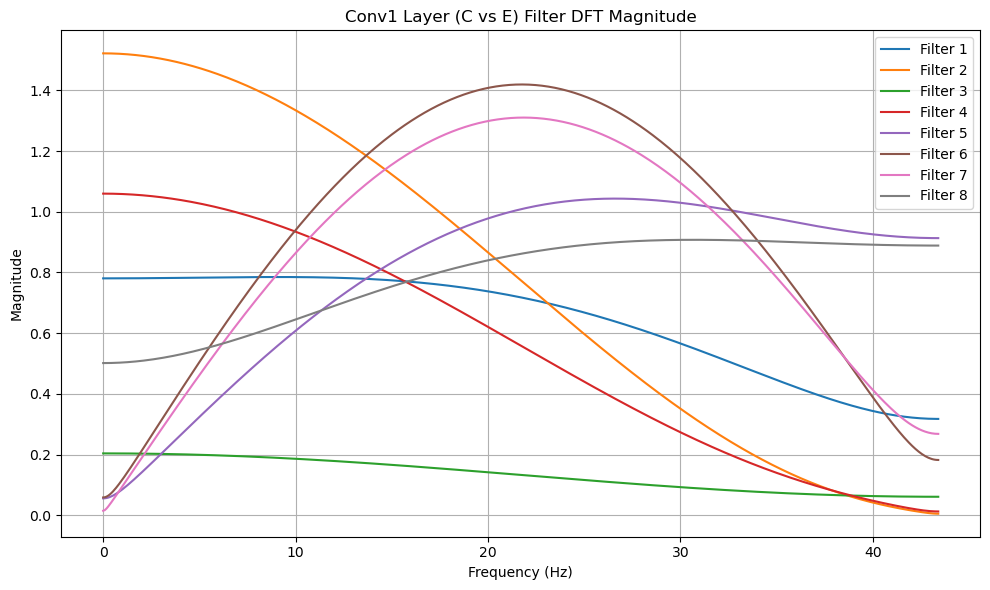

Estimated Lipschitz bound: 33.9609
Per-layer spectral norms: [2.1647387, 2.1549468, 2.7059095, 2.6904438]


In [12]:
# C vs E 
best_lr = train_and_evaluate(processed_C, processed_E, "C", "E", cnn_model, input_len=256)

model_C_E = cnn_model(num_classes=2, input_length=256)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_C_E.parameters(), lr=best_lr, momentum=0.9, weight_decay=1e-4)

X = np.concatenate([processed_C, processed_E], axis=0)
y = np.concatenate([np.zeros(processed_C.shape[0]), np.ones(processed_E.shape[0])])

# train and eval with best LR
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=64, shuffle=True)

for epoch in range(10):
    model_C_E.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_C_E(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("\nFinal model trained — running interpretability...")

# dft learned features
filters = conv1d_filters_to_numpy(model_C_E.conv1)
freqs, mags = compute_dft_magnitude(filters, nfft=1024)
plot_filter_spectra(freqs, mags, fs=173.61, title="Conv1 Layer (C vs E)", save_path="plots/dft_C.png")

# lipschitz continuity 
L_hat, norms = estimate_lipschitz(model_C_E)
print("Estimated Lipschitz bound:", L_hat)
print("Per-layer spectral norms:", norms)

# save model
torch.save(model_C_E.state_dict(), "models/final_model_C_vs_E.pth")

# D vs E Train & Interpretability Visuals


Training Learning Rate: 0.1
Fold 1/10 | Acc: 90.32% | AUC: 0.9603 | Sens: 0.8548 | Spec: 0.9495 | F1: 0.8962
Fold 2/10 | Acc: 89.35% | AUC: 0.9591 | Sens: 0.9208 | Spec: 0.8675 | F1: 0.8942
Fold 3/10 | Acc: 88.87% | AUC: 0.9355 | Sens: 0.8758 | Spec: 0.9020 | F1: 0.8885
Fold 4/10 | Acc: 93.71% | AUC: 0.9767 | Sens: 0.9148 | Spec: 0.9604 | F1: 0.9370
Fold 5/10 | Acc: 87.90% | AUC: 0.9574 | Sens: 0.9159 | Spec: 0.8424 | F1: 0.8830
Fold 6/10 | Acc: 90.65% | AUC: 0.9679 | Sens: 0.9256 | Spec: 0.8875 | F1: 0.9079
Fold 7/10 | Acc: 92.10% | AUC: 0.9672 | Sens: 0.9231 | Spec: 0.9184 | F1: 0.9272
Fold 8/10 | Acc: 90.00% | AUC: 0.9632 | Sens: 0.8833 | Spec: 0.9175 | F1: 0.9003
Fold 9/10 | Acc: 93.23% | AUC: 0.9647 | Sens: 0.9139 | Spec: 0.9497 | F1: 0.9293
Fold 10/10 | Acc: 92.74% | AUC: 0.9678 | Sens: 0.9062 | Spec: 0.9458 | F1: 0.9206
--- Averages for LR 0.1 ---
Mean Acc: 90.89% | Mean AUC: 0.9620 | Mean Sens: 0.9034 | Mean Spec: 0.9141 | Mean F1: 0.9084

Training Learning Rate: 0.01
Fold 1/1

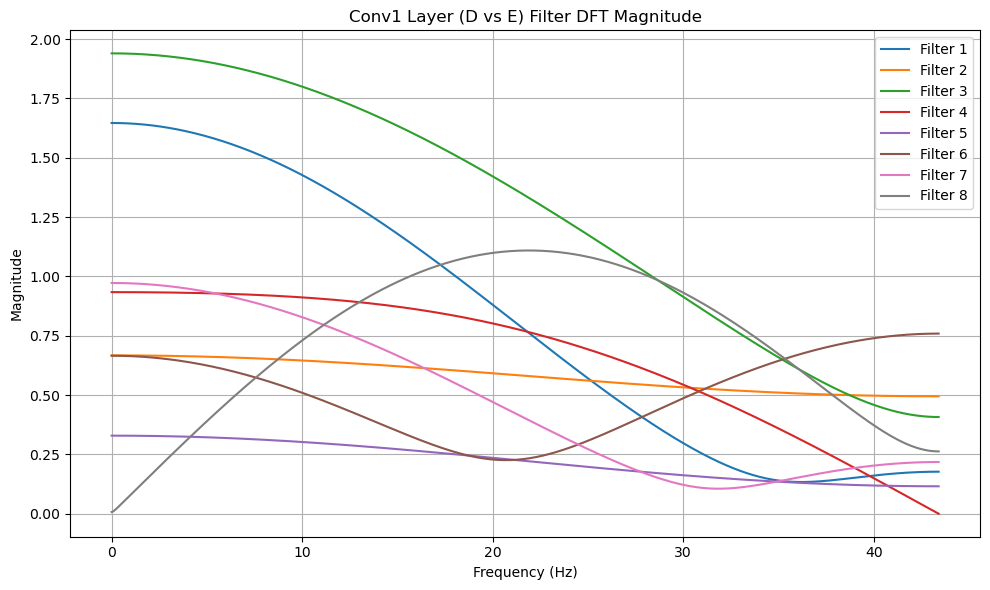

Estimated Lipschitz bound: 31.451273
Per-layer spectral norms: [2.2745447, 2.1861298, 2.3847885, 2.6522713]


In [7]:
# D vs E 
best_lr = train_and_evaluate(processed_D, processed_E, "D", "E", cnn_model, input_len=256)

model_D_E = cnn_model(num_classes=2, input_length=256)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_D_E.parameters(), lr=best_lr, momentum=0.9, weight_decay=1e-4)

X = np.concatenate([processed_D, processed_E], axis=0)
y = np.concatenate([np.zeros(processed_D.shape[0]), np.ones(processed_E.shape[0])])

# train and eval with best LR
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=64, shuffle=True)

for epoch in range(10):
    model_D_E.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_D_E(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("\nFinal model trained — running interpretability...")

# dft learned features
filters = conv1d_filters_to_numpy(model_D_E.conv1)
freqs, mags = compute_dft_magnitude(filters, nfft=1024)
plot_filter_spectra(freqs, mags, fs=173.61, title="Conv1 Layer (D vs E)", save_path="plots/dft_D.png")

# lipschitz continuity 
L_hat, norms = estimate_lipschitz(model_D_E)
print("Estimated Lipschitz bound:", L_hat)
print("Per-layer spectral norms:", norms)

# save model
torch.save(model_D_E.state_dict(), "models/final_model_D_vs_E.pth")

# (A,B) vs E Train & Interpretability Visuals


Training Learning Rate: 0.1
Fold 1/10 | Acc: 96.34% | AUC: 0.9930 | Sens: 0.9215 | Spec: 0.9827 | F1: 0.9408
Fold 2/10 | Acc: 96.34% | AUC: 0.9876 | Sens: 0.9406 | Spec: 0.9745 | F1: 0.9437
Fold 3/10 | Acc: 95.38% | AUC: 0.9914 | Sens: 0.9612 | Spec: 0.9496 | F1: 0.9374
Fold 4/10 | Acc: 95.38% | AUC: 0.9834 | Sens: 0.8767 | Spec: 0.9905 | F1: 0.9244
Fold 5/10 | Acc: 95.59% | AUC: 0.9882 | Sens: 0.8717 | Spec: 0.9968 | F1: 0.9282
Fold 6/10 | Acc: 93.33% | AUC: 0.9806 | Sens: 0.9342 | Spec: 0.9329 | F1: 0.9016
Fold 7/10 | Acc: 95.48% | AUC: 0.9883 | Sens: 0.8954 | Spec: 0.9840 | F1: 0.9288
Fold 8/10 | Acc: 96.88% | AUC: 0.9922 | Sens: 0.9352 | Spec: 0.9868 | F1: 0.9543
Fold 9/10 | Acc: 97.74% | AUC: 0.9949 | Sens: 0.9638 | Spec: 0.9840 | F1: 0.9654
Fold 10/10 | Acc: 94.09% | AUC: 0.9799 | Sens: 0.8502 | Spec: 0.9900 | F1: 0.9100
--- Averages for LR 0.1 ---
Mean Acc: 95.66% | Mean AUC: 0.9880 | Mean Sens: 0.9150 | Mean Spec: 0.9772 | Mean F1: 0.9335

Training Learning Rate: 0.01
Fold 1/1

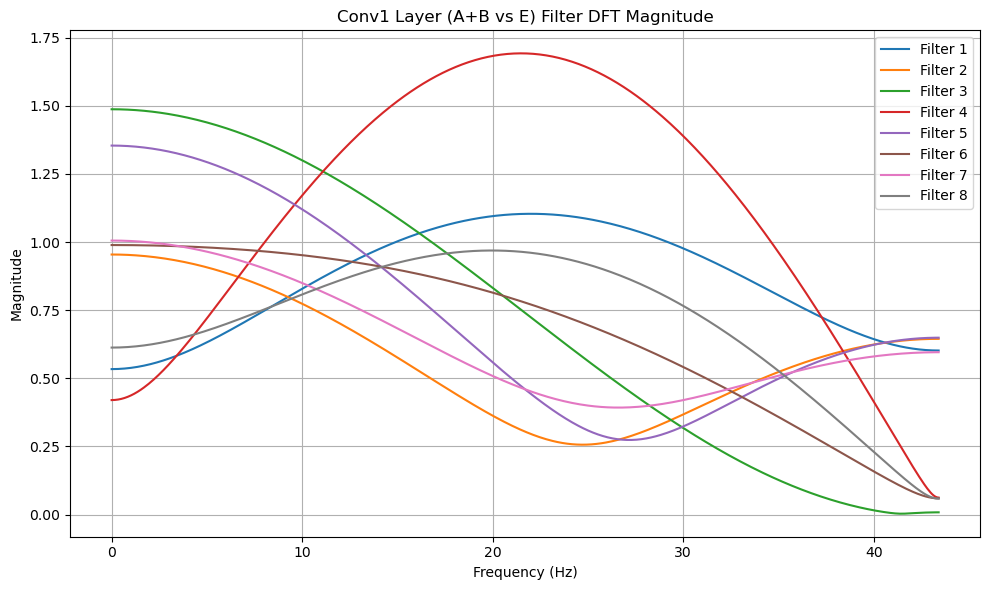

Estimated Lipschitz bound: 36.36612
Per-layer spectral norms: [2.494368, 2.402499, 2.0334682, 2.9842541]


In [8]:
processed_AB = np.concatenate([processed_A, processed_B], axis=0)

best_lr = train_and_evaluate(processed_AB, processed_E, "A+B", "E", cnn_model, input_len=256)

model_AB_E = cnn_model(num_classes=2, input_length=256)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_AB_E.parameters(), lr=best_lr, momentum=0.9, weight_decay=1e-4)

X = np.concatenate([processed_AB, processed_E], axis=0)
y = np.concatenate([np.zeros(processed_AB.shape[0]), np.ones(processed_E.shape[0])])

X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=64, shuffle=True)

for epoch in range(10):
    model_AB_E.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_AB_E(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("\nFinal (A+B) vs E model trained — running interpretability...")

filters = conv1d_filters_to_numpy(model_AB_E.conv1)
freqs, mags = compute_dft_magnitude(filters, nfft=1024)
plot_filter_spectra(freqs, mags, fs=173.61, title="Conv1 Layer (A+B vs E)", save_path="plots/dft_AB.png")

L_hat, norms = estimate_lipschitz(model_AB_E)
print("Estimated Lipschitz bound:", L_hat)
print("Per-layer spectral norms:", norms)

# save model
torch.save(model_AB_E.state_dict(), "models/final_model_AB_vs_E.pth")

# (A,B,C) vs E Train & Interpretability Visuals


Training Learning Rate: 0.1
Fold 1/10 | Acc: 95.40% | AUC: 0.9752 | Sens: 0.8547 | Spec: 0.9852 | F1: 0.8988
Fold 2/10 | Acc: 83.47% | AUC: 0.9598 | Sens: 0.9578 | Spec: 0.7940 | F1: 0.7421
Fold 3/10 | Acc: 92.66% | AUC: 0.9784 | Sens: 0.9329 | Spec: 0.9245 | F1: 0.8652
Fold 4/10 | Acc: 94.03% | AUC: 0.9700 | Sens: 0.8563 | Spec: 0.9704 | F1: 0.8833
Fold 5/10 | Acc: 95.24% | AUC: 0.9844 | Sens: 0.9000 | Spec: 0.9699 | F1: 0.9044
Fold 6/10 | Acc: 94.19% | AUC: 0.9707 | Sens: 0.7864 | Spec: 0.9905 | F1: 0.8657
Fold 7/10 | Acc: 93.39% | AUC: 0.9809 | Sens: 0.9205 | Spec: 0.9382 | F1: 0.8715
Fold 8/10 | Acc: 93.31% | AUC: 0.9734 | Sens: 0.7862 | Spec: 0.9808 | F1: 0.8520
Fold 9/10 | Acc: 93.63% | AUC: 0.9771 | Sens: 0.8059 | Spec: 0.9856 | F1: 0.8740
Fold 10/10 | Acc: 92.98% | AUC: 0.9593 | Sens: 0.8098 | Spec: 0.9690 | F1: 0.8503
--- Averages for LR 0.1 ---
Mean Acc: 92.83% | Mean AUC: 0.9729 | Mean Sens: 0.8611 | Mean Spec: 0.9508 | Mean F1: 0.8607

Training Learning Rate: 0.01
Fold 1/1

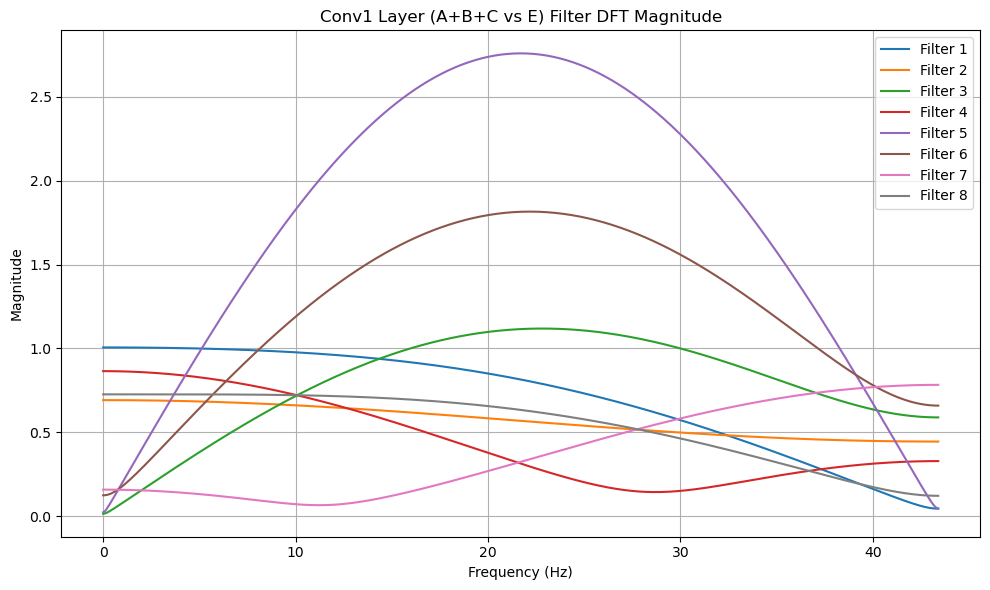

Estimated Lipschitz bound: 45.16331
Per-layer spectral norms: [2.8093235, 2.141097, 2.3517225, 3.1927257]


In [9]:
processed_ABC = np.concatenate([processed_A, processed_B, processed_C], axis=0)

best_lr = train_and_evaluate(processed_ABC, processed_E, "A+B+C", "E", cnn_model, input_len=256)

model_ABC_E = cnn_model(num_classes=2, input_length=256)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ABC_E.parameters(), lr=best_lr, momentum=0.9, weight_decay=1e-4)

X = np.concatenate([processed_ABC, processed_E], axis=0)
y = np.concatenate([np.zeros(processed_ABC.shape[0]), np.ones(processed_E.shape[0])])

X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=64, shuffle=True)

for epoch in range(10):
    model_ABC_E.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_ABC_E(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("\nFinal (A+B+C) vs E model trained — running interpretability...")

filters = conv1d_filters_to_numpy(model_ABC_E.conv1)
freqs, mags = compute_dft_magnitude(filters, nfft=1024)
plot_filter_spectra(freqs, mags, fs=173.61, title="Conv1 Layer (A+B+C vs E)", save_path="plots/dft_ABC.png")

L_hat, norms = estimate_lipschitz(model_ABC_E)
print("Estimated Lipschitz bound:", L_hat)
print("Per-layer spectral norms:", norms)

# save model
torch.save(model_ABC_E.state_dict(), "models/final_model_ABC_vs_E.pth")

# (A,B,C,D) vs E Train & Interpretability Visuals


Training Learning Rate: 0.1
Fold 1/10 | Acc: 84.97% | AUC: 0.9588 | Sens: 0.9214 | Spec: 0.8312 | F1: 0.7155
Fold 2/10 | Acc: 86.77% | AUC: 0.9459 | Sens: 0.8889 | Spec: 0.8627 | F1: 0.7203
Fold 3/10 | Acc: 94.58% | AUC: 0.9782 | Sens: 0.8454 | Spec: 0.9690 | F1: 0.8542
Fold 4/10 | Acc: 92.26% | AUC: 0.9733 | Sens: 0.9206 | Spec: 0.9231 | F1: 0.8286
Fold 5/10 | Acc: 93.74% | AUC: 0.9635 | Sens: 0.7744 | Spec: 0.9761 | F1: 0.8259
Fold 6/10 | Acc: 92.97% | AUC: 0.9605 | Sens: 0.8664 | Spec: 0.9453 | F1: 0.8300
Fold 7/10 | Acc: 92.13% | AUC: 0.9617 | Sens: 0.8571 | Spec: 0.9381 | F1: 0.8190
Fold 8/10 | Acc: 91.81% | AUC: 0.9535 | Sens: 0.7290 | Spec: 0.9653 | F1: 0.7807
Fold 9/10 | Acc: 92.84% | AUC: 0.9431 | Sens: 0.7205 | Spec: 0.9829 | F1: 0.8070
Fold 10/10 | Acc: 92.06% | AUC: 0.9489 | Sens: 0.7757 | Spec: 0.9585 | F1: 0.8019
--- Averages for LR 0.1 ---
Mean Acc: 91.41% | Mean AUC: 0.9587 | Mean Sens: 0.8300 | Mean Spec: 0.9352 | Mean F1: 0.7983

Training Learning Rate: 0.01
Fold 1/1

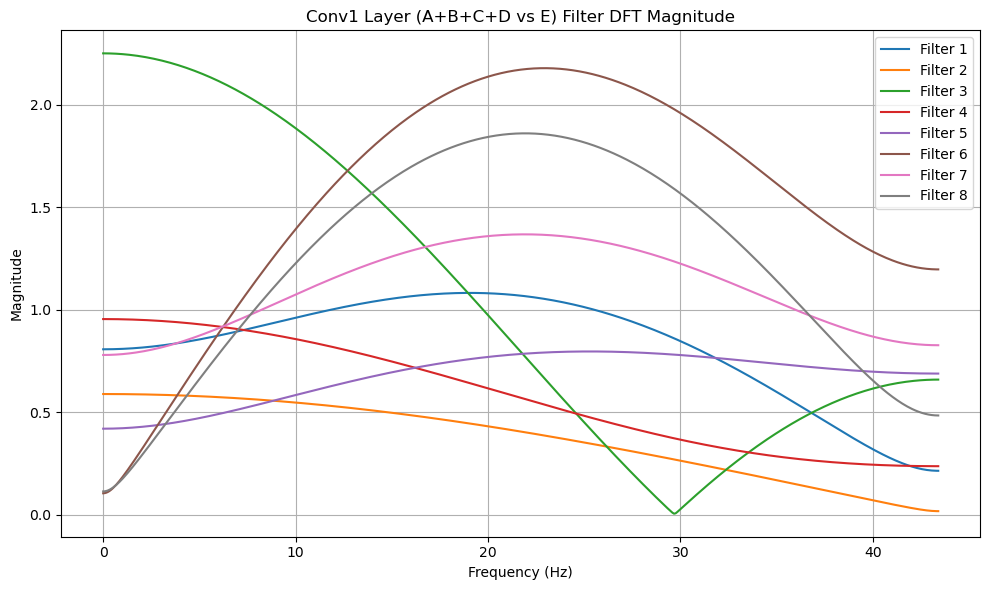

Estimated Lipschitz bound: 58.321712
Per-layer spectral norms: [3.054057, 2.4623992, 2.3228724, 3.3386376]


In [10]:
processed_ABCD = np.concatenate([processed_A, processed_B, processed_C, processed_D], axis=0)

best_lr = train_and_evaluate(processed_ABCD, processed_E, "A+B+C+D", "E", cnn_model, input_len=256)

model_ABCD_E = cnn_model(num_classes=2, input_length=256)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ABCD_E.parameters(), lr=best_lr, momentum=0.9, weight_decay=1e-4)

X = np.concatenate([processed_ABCD, processed_E], axis=0)
y = np.concatenate([np.zeros(processed_ABCD.shape[0]), np.ones(processed_E.shape[0])])

X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=64, shuffle=True)

for epoch in range(10):
    model_ABCD_E.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_ABCD_E(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("\nFinal (A+B+C+D) vs E model trained — running interpretability...")

filters = conv1d_filters_to_numpy(model_ABCD_E.conv1)
freqs, mags = compute_dft_magnitude(filters, nfft=1024)
plot_filter_spectra(freqs, mags, fs=173.61, title="Conv1 Layer (A+B+C+D vs E)", save_path="plots/dft_ABCD.png")

L_hat, norms = estimate_lipschitz(model_ABCD_E)
print("Estimated Lipschitz bound:", L_hat)
print("Per-layer spectral norms:", norms)

# save model
torch.save(model_ABCD_E.state_dict(), "models/final_model_ABCD_vs_E.pth")